[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/multimin/blob/master/examples/multimin_asteroids_application.ipynb)

<p align="left"><img src="https://raw.githubusercontent.com/seap-udea/multimin/master/docs/multimin-logo-white.webp" width="600" /></p>

# Asteroid orbital elements: an application of **multimin**

This notebook goes deeper into the **multimin** module: loading data, building MoGs, and fitting with bounds and multiple components for a particular case, the orbital elements of asteroids.

## Installation

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [55]:
import os
import matplotlib.pyplot as plt
os.makedirs('gallery', exist_ok=True)
try:
    from google.colab import drive
    %pip install -Uq multimin
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2
!mkdir -p gallery/

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiMin.git

Not running in Colab, skipping installation
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the package

Import **multimin** and other required libraries:

In [56]:
import pandas as pd
import numpy as np
import multimin as mn
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

figprefix="asteroids"

## Asteroid data

**multimin** was originally developed to solve the problem of describing the distribution of asteroids in the space of orbital elements. This is a true scientific application of the package that illustrate the power of the methods and the versatility of the numerical methods provided by the package.

Load the dataset (e.g. orbital elements):

In [57]:
# NEA Data
df_neas=pd.read_json(mn.Util.get_data("nea_data.json.gz"))

# Let's filter 10000 asteroids
df_neas=df_neas.sample(10000)

# Let's select the columns we want to fit
df_neas["q"]=df_neas["a"]*(1-df_neas["e"])
data_neas=np.array(df_neas[["q","e","i","Node","Peri","M"]])

Let's see the data:

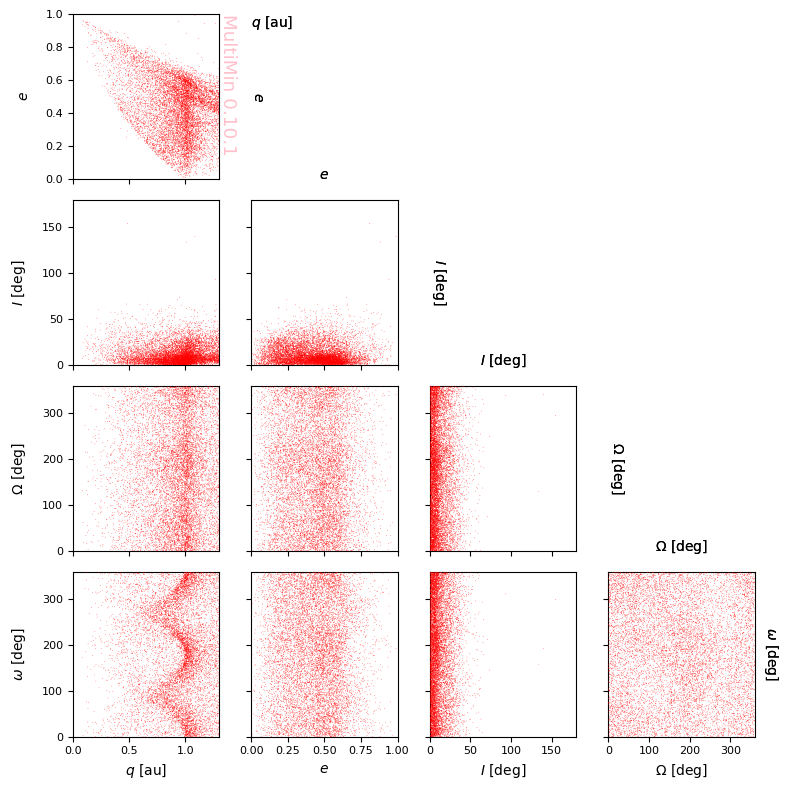

In [58]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
    i=dict(label=r"$I$ [deg]",range=[0.0,180.0]),
    W=dict(label=r"$\Omega$ [deg]",range=[0,360]),
    w=dict(label=r"$\omega$ [deg]",range=[0,360]),
)
G=mn.MultiPlot(properties,figsize=2)

sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.sample_scatter(data_neas,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas.png')


Or a colormesh:

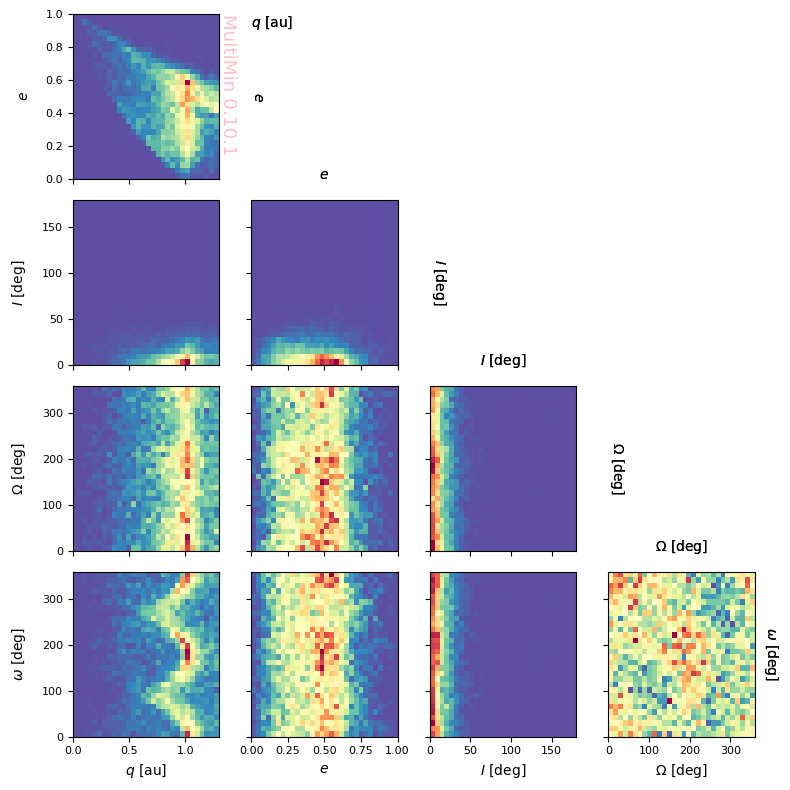

In [59]:
G=mn.MultiPlot(properties,figsize=2)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.sample_hist(data_neas,**hargs)
plt.savefig(f'gallery/{figprefix}_data_neas_hist.png')

### Non-trivially correlated properties

The only elements with a non-trivial distribution are $q, e, I$. Let's study the distribution, for instance, of the $q$ and $e$. For this purpose we need to create a subset:

In [60]:
data_neas_qe=np.array(df_neas[["q","e"]])

And plot it:

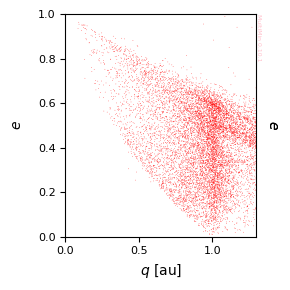

In [61]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)

G=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.sample_scatter(data_neas_qe,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas_qe.png')

Now we will proceed to fit the data against a singled truncated distribution:

In [62]:
t = mn.Util.el_time(0)
F_qe_1 = mn.FitMoG(data=data_neas_qe, ngauss=1, domain=[[0,1.3], [0, 1]])
F_qe_1.fit_data(progress=False)
t = mn.Util.el_time()
print(f"-log(L)/N = {F_qe_1.solution.fun/len(data_neas_qe)}")

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1.3], [0, 1]]
Log-likelihood per point (-log L/N): 0.30781041041638746
__autoreload_class__.fit_data executed in 0.22311973571777344 seconds
Elapsed time since last call: 237.729 ms
-log(L)/N = -0.5343252888158647


And check the fit result:

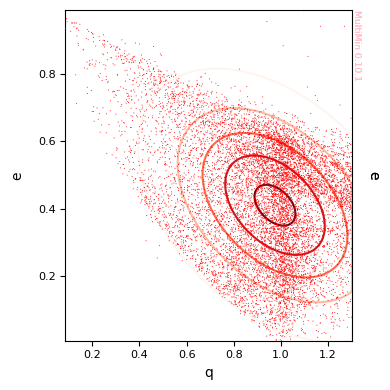

In [63]:
# properties: list of names or dict like MultiPlot (e.g. dict(q=dict(label=r"$q$", range=None), ...))
properties=["q","e"]
pargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
cargs=dict()
G=F_qe_1.plot_fit(
    properties=properties,
    #pargs=hargs,
    pargs=None,
    sargs=sargs,
    cargs=cargs,
    figsize=4
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_1gauss.png')


In [64]:
F_qe_1.mog.tabulate()

,w,mu_1,mu_2,sigma_1,sigma_2,rho_12
component,,,,,,
1,1.0,0.974537,0.410461,0.270261,0.188596,-0.426339


We can do it better increasing the number of normals:

In [65]:
t = mn.Util.el_time(0)
F = mn.FitMoG(data=data_neas_qe, ngauss=5, domain=[[0,1.3], [0, 1]])
F.fit_data(advance=50)
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(data_neas_qe)}")

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 2
Number of dimensions: 10
Number of samples: 10000
Domain: [[0, 1.3], [0, 1]]
Log-likelihood per point (-log L/N): 0.24691846606274012
Iterations:
Iter 0:
	Vars: [-1.5, -1.3, -1.3, -1.3, -1.5, 0.47, 0.14, 0.82, 0.32, 0.96, 0.45, 1, 0.55, 1.2, 0.71, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, 0.7, 0.63, 0.71, 0.42, 1.1]
	LogL/N: 2.077178284385907
Iter 50:
	Vars: [-2.2, -0.89, -0.8, -1.3, -1.8, 0.71, 0.27, 1.1, 0.44, 1, 0.26, 1, 0.57, 0.96, 0.53, -4.5, -4.7, -3.1, -4.3, -4.6, -4.4, -3.2, -4.2, -4.4, -5, -1.7, -1.3, -0.27, -3.7, 0.22]
	LogL/N: -0.6925523584562886
Iter 100:
	Vars: [-2.2, -0.58, -0.87, -1.4, -2, 0.69, 0.27, 1, 0.45, 0.99, 0.25, 1.3, 0.47, 1, 0.52, -4.2, -4.5, -3.4, -4.3, -4.5, -4.5, -2.9, -3.9, -4.9, -5, -2.6, -1.4, -0.57, -4.3, -0.09]
	LogL/N: -0.7044587125178927
Iter 150:
	Vars: [-2.2, -0.38, -1.2, -1.1, -2.2, 0.72, 0.24, 0.96, 0.45, 0.99, 0.24, 1.3, 0.46, 1, 0.48, -4, -4.3, -3.5, -4.3, 

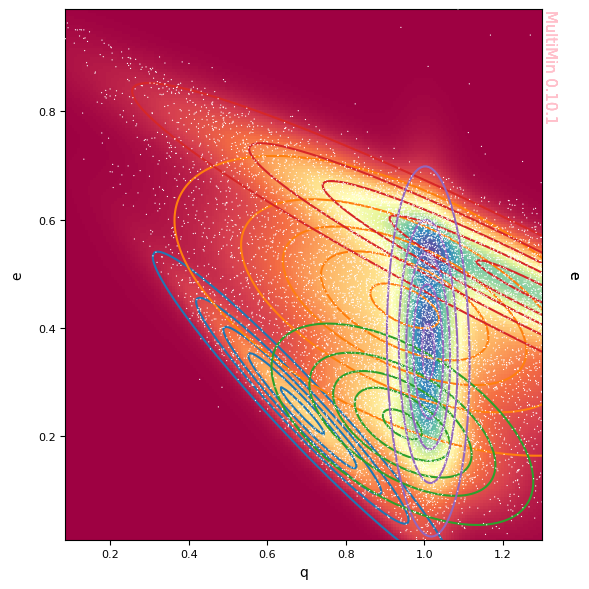

In [66]:
properties = ["q","e"]
sargs = dict(s=0.8,edgecolor='None',color='w')
pargs = dict(cmap='Spectral')
cargs = dict(decomp=True, legend=False)
G=F.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    cargs=cargs,
    figsize=6,
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_decomposition.png')

Another way of comparing is to generate a sample with the fitted distribution and compare it with the original one:

In [67]:
neas_sample = F.mog.rvs(len(data_neas_qe))

__autoreload_class__.rvs executed in 0.824843168258667 seconds


And plot it:

Text(0.5, 1.0, 'Original data')

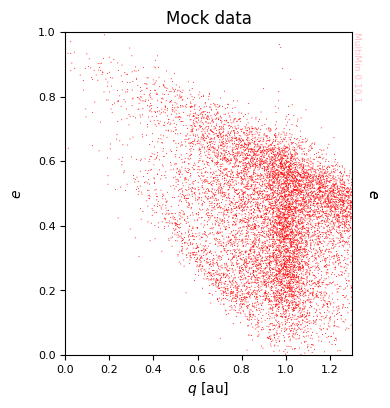

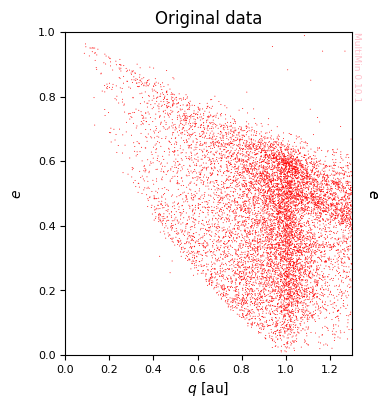

In [68]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
# Mock data
G = mn.MultiPlot(properties,figsize=4)
G.sample_scatter(neas_sample,**sargs)
G.axs[0][0].set_title("Mock data")
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_sample.png')
# True data
G=mn.MultiPlot(properties,figsize=4)
scatter=G.sample_scatter(data_neas_qe,**sargs)
G.axs[0][0].set_title("Original data")


Let's see the fit function:

In [69]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
table = F.mog.tabulate(properties=properties)
table

,w,mu_q,mu_e,sigma_q,sigma_e,rho_qe
component,,,,,,
2,0.361394,0.949759,0.440776,0.272952,0.128942,-0.569812
4,0.265890,1.285112,0.468150,0.479506,0.178947,-0.960466
5,0.164177,1.009594,0.356500,0.048947,0.159238,-0.072115
3,0.149007,0.943863,0.222068,0.155197,0.086594,-0.568736
1,0.059532,0.689262,0.246983,0.177482,0.136920,-0.967852


In [70]:
function, mog = F.mog.get_function(properties=properties)

import numpy as np
from multimin import Util

def mog(X):

    a = [0.0, 0.0]
    b = [1.3, 1.0]

    mu1_q = 0.689262
    mu1_e = 0.246983
    mu1 = [mu1_q, mu1_e]
    Sigma1 = [[0.0315, -0.02352], [-0.02352, 0.018747]]
    Z1 = 0.964322
    n1 = Util.tnmd(X, mu1, Sigma1, a, b, Z=Z1)

    mu2_q = 0.949759
    mu2_e = 0.440776
    mu2 = [mu2_q, mu2_e]
    Sigma2 = [[0.074503, -0.020054], [-0.020054, 0.016626]]
    Z2 = 0.899973
    n2 = Util.tnmd(X, mu2, Sigma2, a, b, Z=Z2)

    mu3_q = 0.943863
    mu3_e = 0.222068
    mu3 = [mu3_q, mu3_e]
    Sigma3 = [[0.024086, -0.007643], [-0.007643, 0.007498]]
    Z3 = 0.98508
    n3 = Util.tnmd(X, mu3, Sigma3, a, b, Z=Z3)

    mu4_q = 1.285112
    mu4_e = 0.46815
    mu4 = [mu4_q, mu4_e]
    Sigma4 = [[0.229926, -0.082414], [-0.082414, 0.032022]]
    Z4 = 0.508552
    n4 = Util.tnmd(X, mu4, Sigma4, a, b, Z=Z4)

    mu5_q = 1.009594
    mu5_e = 0.3565
    mu5 = [mu5_q, mu5_e]
    Sigma5 = [[0.002396, -0.000562], [-0.000562, 0.025357]]
    Z5 = 0.

### Fitting other pair of properties

Fitting $q$ and $I$:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1.3], [0, 180]]
Log-likelihood per point (-log L/N): 132.44560497144275
__autoreload_class__.fit_data executed in 0.06797599792480469 seconds
-log(L)/N = 3.4919723254670467


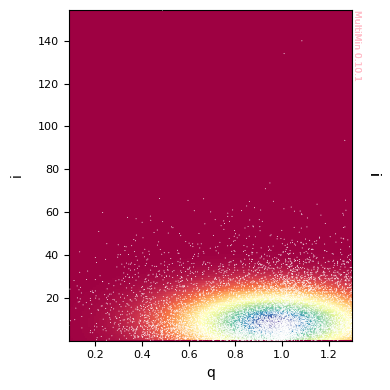

In [71]:
data_neas_qi=np.array(df_neas[["q","i"]])
F_qi_1 = mn.FitMoG(data=data_neas_qi, ngauss=1, domain=[[0,1.3], [0, 180]])
F_qi_1.fit_data(progress=False)
print(f"-log(L)/N = {F_qi_1.solution.fun/len(data_neas_qi)}")

properties=["q","i"]
sargs=dict(s=0.5,edgecolor='None',color='w')
pargs=dict(cmap='Spectral')
G=F_qi_1.plot_fit(properties=properties,pargs=pargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qi_1gauss.png')

Fitting $e$ and $I$:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1], [0, 180]]
Log-likelihood per point (-log L/N): 135.20326864854917
__autoreload_class__.fit_data executed in 0.07596397399902344 seconds
-log(L)/N = 3.310903890235546


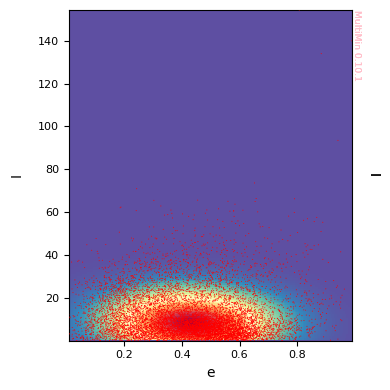

In [72]:
data_neas_ei=np.array(df_neas[["e","i"]])
F_ei_1 = mn.FitMoG(data=data_neas_ei, ngauss=1, domain=[[0,1], [0, 180]])
F_ei_1.fit_data(progress=False)
print(f"-log(L)/N = {F_ei_1.solution.fun/len(data_neas_ei)}")

properties=["e","I"]
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_ei_1.plot_fit(properties=properties,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_ei_1gauss.png')

### Fitting three variables: $q, e, I$

Let's extract first the data:

In [73]:
data_neas_qei = np.array(df_neas[["q","e","i"]])

Let's plot the original data:

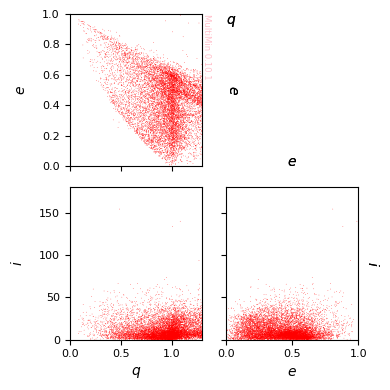

In [74]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

G = mn.MultiPlot(properties, figsize=2)
sargs = dict(s=0.2, edgecolor='None', color='r')
scatter = G.sample_scatter(data_neas_qei, **sargs)
plt.savefig(f'gallery/{figprefix}_data_neas_qei.png')


Now let's try to fit this data using truncated multivariate distribution:

In [ ]:
fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.fit_data(progress="tqdm", normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

properties=["q","e","i"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    sargs=sargs,
    pargs=pargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_simple.png')

As you see, without information the fit is not too successful. We will try a different approach.

**Initial parameters from partial fits.** The 1-Gaussian fit in (q,e,i) often misses the q–e correlation when started from generic initial values. We use the three 2D fits (F_qe_1, F_qi_1, F_ei_1) to build initial means, sigmas, and correlations for the full 3D fit: each mean/sigma is averaged over the two partial fits that contain that variable; each correlation comes from the single partial fit that contains that pair.

In [82]:
# Initial (mus, sigmas, rhos) from partial fits F_qe_1, F_qi_1, F_ei_1 (vars: 0=q, 1=e, 2=i)
mu_q = (F_qe_1.mog.mus[0, 0] + F_qi_1.mog.mus[0, 0]) / 2
mu_e = (F_qe_1.mog.mus[0, 1] + F_ei_1.mog.mus[0, 0]) / 2
mu_i = (F_qi_1.mog.mus[0, 1] + F_ei_1.mog.mus[0, 1]) / 2
sigma_q = (F_qe_1.mog.sigmas[0, 0] + F_qi_1.mog.sigmas[0, 0]) / 2
sigma_e = (F_qe_1.mog.sigmas[0, 1] + F_ei_1.mog.sigmas[0, 0]) / 2
sigma_i = (F_qi_1.mog.sigmas[0, 1] + F_ei_1.mog.sigmas[0, 1]) / 2
rho_qe = float(F_qe_1.mog.rhos[0, 0])
rho_qi = float(F_qi_1.mog.rhos[0, 0])
rho_ei = float(F_ei_1.mog.rhos[0, 0])

fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)
#fit_qei.set_bounds(boundsm=((0.8, 1.2), (0.0, 1.0), (0.0, 15.0)))
fit_qei.fit_data(progress="tqdm", normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Domain: [[0, 1.3], [0, 1.0], [0, 180]]
Log-likelihood per point (-log L/N): 145.2770156743629


Minimizing: 0it [00:00, ?it/s]

__autoreload_class__.fit_data executed in 0.2738621234893799 seconds
-log(L)/N = -2.3549286071960602


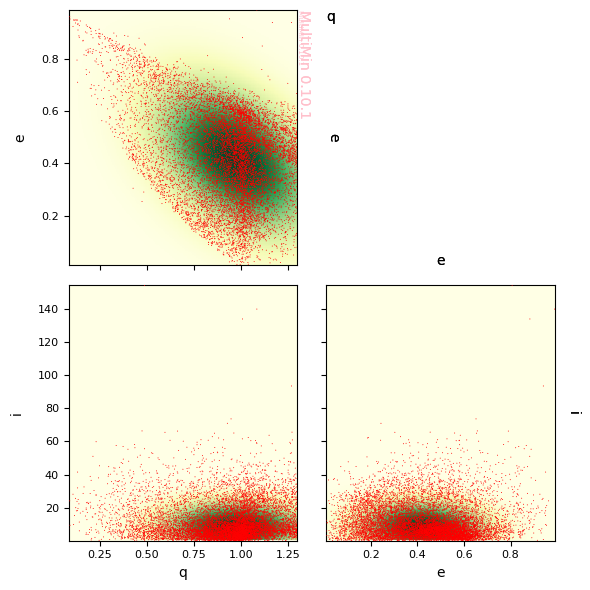

In [83]:
properties=["q","e","i"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_feed.png')

Much better!

Let's try with more gaussians:

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 3
Number of dimensions: 15
Number of samples: 10000
Domain: [[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]]
Log-likelihood per point (-log L/N): 337.56206784226816


Minimizing: 0it [00:00, ?it/s]

__autoreload_class__.fit_data executed in 5.4216039180755615 seconds


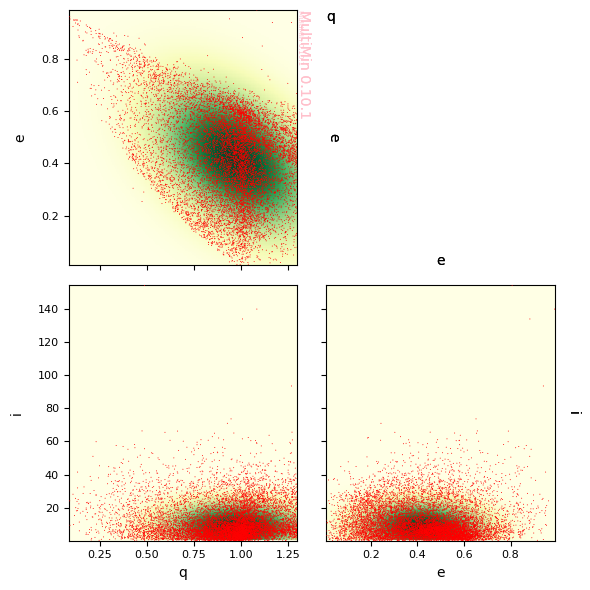

In [84]:
fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=5, domain=[[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]])

fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)

fit_qei.fit_data(progress="tqdm")
G=fit_qei.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_ngauss.png')

The problem is that the fit is not converging to a good representation of the distribution.

### Transforming data

Orbital elements such as $q$, $e$, and $i$ live in **finite intervals** (e.g. $q \in [0, q_{\max}]$, $e \in [0, 1)$, $i \in [0, \pi]$), while the MoG is defined on the whole real line. To fit a normal mixture on unbounded variables we first map each bounded variable to an unbounded one via a **logistic-type (log-odds) transformation** (see e.g. the *manuscript-neoflux* formalism).

For a variable $x \in (0, x_{\max})$, define the **unbound** variable:

$$u = \log\left(\frac{x/x_{\max}}{1 - x/x_{\max}}\right)$$

so that $u \in (-\infty, +\infty)$. The inverse map is:

$$x = \frac{x_{\max}}{1 + \exp(-u)}$$

In the notebook we use this with $q_{\max}=1.35$ au, $e_{\max}=1$, $i_{\max}=\pi$ to obtain unbound variables $(Q, C, I)$. Fitting the MoG in $(Q, C, I)$ and then transforming back preserves normalization and often improves conditioning; the same transformation is used in the manuscript for the NEO flux formalism.

Transform variables to an unbounded scale for fitting (e.g. with `Util.t_if` / `f2u`):

In [ ]:
scales=[1.35,1.00,180.0]
udata=np.zeros_like(data_neas_qei)
for i in range(len(data_neas_qei)):
    udata[i]=mn.Util.t_if(data_neas_qei[i],scales,mn.Util.f2u)

Visualize the data with **MultiPlot** (scatter on pairwise panels):

In [ ]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$C$",range=None),
    I=dict(label=r"$I$",range=None),
)
G=mn.MultiPlot(properties,figsize=3)

sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.sample_scatter(udata,**sargs)

plt.savefig('gallery/indepth_data_scatter_QCI.png')


The same idea (initial parameters from partial fits) can be reused for multi-component fits below.

You can also show 2D histograms on the panels:

In [ ]:
G=mn.MultiPlot(properties,figsize=3)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.sample_hist(udata,colorbar=True,**hargs)

plt.savefig('gallery/multimin_indepth_2.png')


Create the fitter (e.g. one Gaussian, three variables):

In [ ]:
F=mn.FitMoG(data=udata, ngauss=1)

The fitter holds an initial MoG that will be optimized:

In [ ]:
print(F.mog)

Run the minimization:

In [ ]:
t = mn.Util.el_time(0)
F.fit_data(verbose=False,progress="tqdm")
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(udata)}")

Inspect the fitted MoG:

In [ ]:
print(F.mog)

Plot the fit result (fitted sample + data scatter):

In [ ]:
properties=["Q","C","I"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.2,edgecolor='None',color='r')
cargs=dict()
G=F.plot_fit(properties=properties,sargs=sargs,cargs=cargs,pargs=pargs,figsize=3)

plt.savefig(f'gallery/{figprefix}_indepth_fit_result_QCI.png')


Fitting can be time-consuming; you can save the result for later use:

In [ ]:
F.save_fit(f"gallery/{figprefix}_fit-single.pkl",useprefix=False)

Load a previously saved fit (here or in another notebook):

In [ ]:
F=mn.FitMoG(f"gallery/{figprefix}_fit-single.pkl")
print(F.mog)

Fit with two Gaussian components for a better likelihood:

In [ ]:
F=mn.FitMoG(data=udata, ngauss=2)

mn.Util.el_time(0)
F.fit_data(progress="tqdm")
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)

G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig(f"gallery/{figprefix}_fit-multiple-{F.prefix}.png")

Using two components improves the fit (lower $-\log\mathcal{L}/N$).

You can set bounds on parameters (e.g. means, weights) to avoid unphysical solutions:

In [ ]:
F=mn.FitMoG(data=udata, ngauss=2)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,progress="tqdm",bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple-bounds.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig("gallery/indepth_fit_2gauss_bounds_QCI.png")

Fitting with five Gaussians can capture more structure:

In [ ]:
F=mn.FitMoG(data=udata, ngauss=5)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(progress="tqdm",bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/fit-multiple-bound_mus.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig(f"gallery/{figprefix}_fit_5gauss_bound_mus_QCI.png")

As you can see the fitting parameter $-\log{\cal L}$ is improved with respect to previous fit. 

Verify the fit by generating a sample from the fitted MoG and comparing to the data:

In [ ]:
F.mog.plot_sample(N=len(F.data),
                  figsize=3,
                  properties=["Q","C","I"],ranges=[[-5,5],[-6,6],[-8,2]],
                  sargs=dict(s=0.2,edgecolor='None',color='r'))
G.fig.savefig(f"gallery/{figprefix}_sample_from_fit_20gauss_QCI.png")

properties=dict(
    Q=dict(label=r"$Q$",range=[-5,5]),
    C=dict(label=r"$C$",range=[-6,6]),
    I=dict(label=r"$I$",range=[-8,2]),
)
G=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.sample_scatter(udata,**sargs)

We can also check the original distribution:

In [ ]:
scales=[1.35,1.00,180.0]
usample = F.mog.rvs(len(udata))
rsample=np.zeros_like(usample)
for i in range(len(usample)):
    rsample[i] = mn.Util.t_if(usample[i], scales, mn.Util.u2f)

In [ ]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

Gt=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='b')
scatter_transformed=Gt.sample_scatter(rsample,**sargs)
Gt.fig.suptitle(f"Transformed Sample from Fit with {F.ngauss} Gaussians")
Gt.fig.tight_layout()
Gt.fig.savefig(f"gallery/{figprefix}_sample_from_fit_ngauss_qei.png")

Go=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter_original=Go.sample_scatter(data_neas_qei,**sargs)

In [ ]:
function, mog = F.mog.get_function(properties=properties)

---

**MultiMin** - Multivariate Gaussian fitting

© 2026 Jorge I. Zuluaga